## Bộ phân loại ẩm thực 1

Trong bài học này, chúng ta sẽ khám phá nhiều bộ phân loại để *dự đoán một nền ẩm thực quốc gia dựa trên nhóm nguyên liệu.* Trong quá trình này, chúng ta sẽ tìm hiểu thêm về cách các thuật toán có thể được sử dụng cho các nhiệm vụ phân loại.

### [**Câu hỏi trước bài học**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Chuẩn bị**

Bài học này dựa trên [bài học trước](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) nơi chúng ta:

-   Đã giới thiệu nhẹ nhàng về phân loại bằng cách sử dụng một tập dữ liệu về tất cả các nền ẩm thực tuyệt vời của châu Á và Ấn Độ 😋.

-   Đã khám phá một số [động từ dplyr](https://dplyr.tidyverse.org/) để chuẩn bị và làm sạch dữ liệu.

-   Đã tạo các hình ảnh trực quan đẹp mắt bằng ggplot2.

-   Đã trình bày cách xử lý dữ liệu không cân bằng bằng cách tiền xử lý nó bằng [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Đã trình bày cách `prep` và `bake` công thức của chúng ta để xác nhận rằng nó hoạt động như mong đợi.

#### **Điều kiện tiên quyết**

Đối với bài học này, chúng ta sẽ cần các gói sau để làm sạch, chuẩn bị và trực quan hóa dữ liệu:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) là một [bộ sưu tập các gói R](https://www.tidyverse.org/packages) được thiết kế để làm cho khoa học dữ liệu nhanh hơn, dễ dàng hơn và thú vị hơn!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) là một [khung làm việc gồm các gói](https://www.tidymodels.org/packages/) dành cho mô hình hóa và học máy.

-   `themis`: [gói themis](https://themis.tidymodels.org/) cung cấp các bước bổ sung trong công thức để xử lý dữ liệu không cân bằng.

-   `nnet`: [gói nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) cung cấp các hàm để ước tính mạng nơ-ron truyền thẳng với một lớp ẩn, và các mô hình hồi quy logistic đa thức.

Bạn có thể cài đặt chúng như sau:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Ngoài ra, đoạn mã dưới đây sẽ kiểm tra xem bạn đã có các gói cần thiết để hoàn thành mô-đun này chưa và sẽ cài đặt chúng nếu chúng bị thiếu.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Chia dữ liệu thành tập huấn luyện và tập kiểm tra.

Chúng ta sẽ bắt đầu bằng cách chọn một vài bước từ bài học trước.

### Loại bỏ các nguyên liệu phổ biến nhất gây nhầm lẫn giữa các nền ẩm thực khác nhau, sử dụng `dplyr::select()`.

Ai cũng yêu thích cơm, tỏi và gừng!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


Tuyệt vời! Bây giờ, chúng ta sẽ chia dữ liệu sao cho 70% dữ liệu dành cho huấn luyện và 30% dành cho kiểm tra. Chúng ta cũng sẽ áp dụng kỹ thuật `phân tầng` khi chia dữ liệu để `duy trì tỷ lệ của mỗi loại ẩm thực` trong các tập dữ liệu huấn luyện và kiểm tra.

[rsample](https://rsample.tidymodels.org/), một gói trong Tidymodels, cung cấp cơ sở hạ tầng cho việc chia dữ liệu và lấy mẫu lại một cách hiệu quả:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. Xử lý dữ liệu không cân bằng

Như bạn có thể đã nhận thấy trong tập dữ liệu gốc cũng như trong tập huấn luyện của chúng ta, có sự phân bố không đồng đều về số lượng các loại ẩm thực. Các món ăn Hàn Quốc *gần như* gấp 3 lần các món ăn Thái. Dữ liệu không cân bằng thường ảnh hưởng tiêu cực đến hiệu suất của mô hình. Nhiều mô hình hoạt động tốt nhất khi số lượng quan sát là bằng nhau và do đó thường gặp khó khăn với dữ liệu không cân bằng.

Có hai cách chính để xử lý các tập dữ liệu không cân bằng:

-   thêm các quan sát vào lớp thiểu số: `Over-sampling`, ví dụ sử dụng thuật toán SMOTE, thuật toán này tạo ra các ví dụ mới cho lớp thiểu số một cách tổng hợp bằng cách sử dụng các hàng xóm gần nhất của các trường hợp này.

-   loại bỏ các quan sát từ lớp đa số: `Under-sampling`

Trong bài học trước, chúng ta đã minh họa cách xử lý các tập dữ liệu không cân bằng bằng cách sử dụng một `recipe`. Recipe có thể được coi như một bản hướng dẫn mô tả các bước cần áp dụng cho một tập dữ liệu để chuẩn bị cho việc phân tích dữ liệu. Trong trường hợp của chúng ta, chúng ta muốn có sự phân bố đồng đều về số lượng các loại ẩm thực trong `training set`. Hãy bắt đầu ngay thôi.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Bạn có thể xác nhận (bằng cách chuẩn bị và thực hiện) rằng công thức này sẽ hoạt động như mong đợi - tất cả các nhãn ẩm thực đều có `559` quan sát.

Vì chúng ta sẽ sử dụng công thức này như một bộ tiền xử lý cho việc mô hình hóa, một `workflow()` sẽ thực hiện toàn bộ việc chuẩn bị và thực hiện cho chúng ta, vì vậy chúng ta sẽ không phải ước tính công thức một cách thủ công.

Bây giờ chúng ta đã sẵn sàng để huấn luyện một mô hình 👩‍💻👨‍💻!

## 3. Lựa chọn bộ phân loại của bạn

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Tác phẩm nghệ thuật của @allison_horst</figcaption>


Bây giờ chúng ta cần quyết định thuật toán nào sẽ được sử dụng cho công việc này 🤔.

Trong Tidymodels, [`gói parsnip`](https://parsnip.tidymodels.org/index.html) cung cấp giao diện nhất quán để làm việc với các mô hình trên các engine (gói) khác nhau. Vui lòng xem tài liệu của parsnip để khám phá [các loại mô hình & engine](https://www.tidymodels.org/find/parsnip/#models) và [các tham số mô hình tương ứng](https://www.tidymodels.org/find/parsnip/#model-args). Ban đầu, sự đa dạng này có thể khiến bạn choáng ngợp. Ví dụ, các phương pháp sau đây đều bao gồm các kỹ thuật phân loại:

-   Mô hình phân loại dựa trên quy tắc C5.0

-   Mô hình phân biệt linh hoạt

-   Mô hình phân biệt tuyến tính

-   Mô hình phân biệt có điều chỉnh

-   Mô hình hồi quy logistic

-   Mô hình hồi quy đa thức

-   Mô hình Naive Bayes

-   Máy vector hỗ trợ

-   Láng giềng gần nhất

-   Cây quyết định

-   Phương pháp tập hợp

-   Mạng nơ-ron

Danh sách này còn tiếp tục!

### **Nên chọn bộ phân loại nào?**

Vậy, bạn nên chọn bộ phân loại nào? Thông thường, thử nghiệm qua nhiều bộ phân loại và tìm kiếm kết quả tốt là một cách để kiểm tra.

> AutoML giải quyết vấn đề này một cách gọn gàng bằng cách chạy các so sánh này trên đám mây, cho phép bạn chọn thuật toán tốt nhất cho dữ liệu của mình. Hãy thử tại đây [here](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Ngoài ra, việc lựa chọn bộ phân loại còn phụ thuộc vào vấn đề của chúng ta. Ví dụ, khi kết quả có thể được phân loại thành `nhiều hơn hai lớp`, như trong trường hợp của chúng ta, bạn phải sử dụng một `thuật toán phân loại đa lớp` thay vì `phân loại nhị phân.`

### **Một cách tiếp cận tốt hơn**

Tuy nhiên, một cách tốt hơn thay vì đoán mò là làm theo các ý tưởng trong [bảng tham khảo nhanh ML](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) có thể tải xuống này. Tại đây, chúng ta phát hiện rằng, đối với vấn đề phân loại đa lớp của mình, chúng ta có một số lựa chọn:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Một phần của Bảng tham khảo thuật toán của Microsoft, chi tiết các tùy chọn phân loại đa lớp</figcaption>


### **Lý do**

Hãy xem xét các cách tiếp cận khác nhau dựa trên các giới hạn mà chúng ta có:

-   **Mạng nơ-ron sâu quá nặng**. Với tập dữ liệu sạch nhưng tối thiểu của chúng ta, và việc huấn luyện được thực hiện cục bộ qua notebook, mạng nơ-ron sâu là quá nặng nề cho nhiệm vụ này.

-   **Không sử dụng bộ phân loại hai lớp**. Chúng ta không sử dụng bộ phân loại hai lớp, vì vậy loại bỏ phương pháp one-vs-all.

-   **Cây quyết định hoặc hồi quy logistic có thể phù hợp**. Cây quyết định có thể hoạt động, hoặc hồi quy đa thức/hồi quy logistic đa lớp cho dữ liệu đa lớp.

-   **Cây quyết định tăng cường đa lớp giải quyết vấn đề khác**. Cây quyết định tăng cường đa lớp phù hợp nhất cho các nhiệm vụ phi tham số, ví dụ như các nhiệm vụ thiết kế xếp hạng, vì vậy nó không hữu ích cho chúng ta.

Ngoài ra, thông thường trước khi bắt đầu với các mô hình học máy phức tạp hơn như phương pháp ensemble, nên xây dựng mô hình đơn giản nhất có thể để hiểu rõ vấn đề. Vì vậy, trong bài học này, chúng ta sẽ bắt đầu với mô hình `hồi quy đa thức`.

> Hồi quy logistic là một kỹ thuật được sử dụng khi biến kết quả là biến phân loại (hoặc danh nghĩa). Đối với hồi quy logistic nhị phân, số lượng biến kết quả là hai, trong khi số lượng biến kết quả đối với hồi quy logistic đa thức là nhiều hơn hai. Xem [Phương pháp hồi quy nâng cao](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) để tìm hiểu thêm.

## 4. Huấn luyện và đánh giá mô hình hồi quy logistic đa thức.

Trong Tidymodels, `parsnip::multinom_reg()` định nghĩa một mô hình sử dụng các dự đoán tuyến tính để dự đoán dữ liệu đa lớp bằng cách sử dụng phân phối đa thức. Xem `?multinom_reg()` để biết các cách/engine khác nhau mà bạn có thể sử dụng để huấn luyện mô hình này.

Trong ví dụ này, chúng ta sẽ huấn luyện mô hình hồi quy đa thức thông qua engine mặc định [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Tôi đã chọn giá trị cho `penalty` một cách ngẫu nhiên. Có những cách tốt hơn để chọn giá trị này, đó là sử dụng `resampling` và `tuning` mô hình, điều mà chúng ta sẽ thảo luận sau.
>
> Xem [Tidymodels: Bắt đầu](https://www.tidymodels.org/start/tuning/) nếu bạn muốn tìm hiểu thêm về cách tinh chỉnh siêu tham số của mô hình.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Làm tốt lắm 🥳! Bây giờ chúng ta đã có một công thức và một mô tả mô hình, chúng ta cần tìm cách kết hợp chúng lại thành một đối tượng để trước tiên xử lý dữ liệu, sau đó khớp mô hình trên dữ liệu đã được xử lý, và cũng cho phép các hoạt động xử lý sau tiềm năng. Trong Tidymodels, đối tượng tiện lợi này được gọi là [`workflow`](https://workflows.tidymodels.org/) và nó tiện lợi lưu giữ các thành phần mô hình của bạn! Đây là điều chúng ta gọi là *pipelines* trong *Python*.

Vậy hãy kết hợp mọi thứ lại thành một workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Quy trình làm việc 👌👌! Một **`workflow()`** có thể được điều chỉnh tương tự như cách một mô hình có thể. Vậy, đến lúc huấn luyện một mô hình rồi!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Các hệ số mà mô hình đã học được trong quá trình huấn luyện được hiển thị ở đầu ra.

### Đánh giá Mô hình Đã Huấn Luyện

Đã đến lúc xem mô hình hoạt động như thế nào 📏 bằng cách đánh giá nó trên tập kiểm tra! Hãy bắt đầu bằng việc tạo dự đoán trên tập kiểm tra.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


Làm tốt lắm! Trong Tidymodels, việc đánh giá hiệu suất mô hình có thể được thực hiện bằng cách sử dụng [yardstick](https://yardstick.tidymodels.org/) - một gói dùng để đo lường hiệu quả của các mô hình bằng các chỉ số hiệu suất. Như chúng ta đã làm trong bài học hồi quy logistic, hãy bắt đầu bằng cách tính ma trận nhầm lẫn.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Khi xử lý nhiều lớp, thường trực quan hơn khi hình dung điều này dưới dạng bản đồ nhiệt, như thế này:


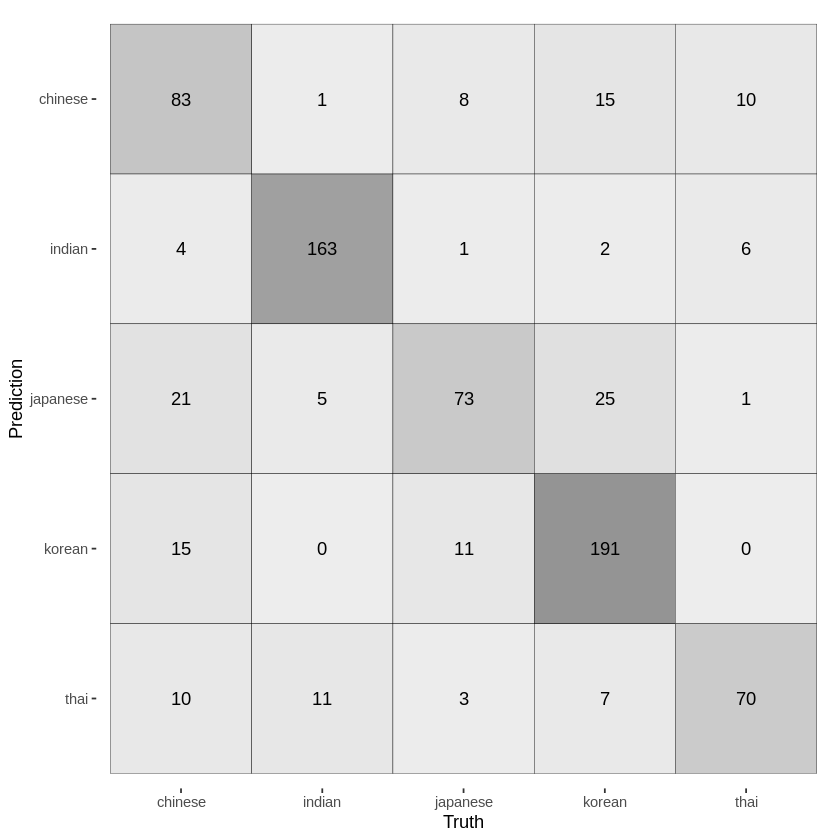

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Các ô vuông tối màu hơn trong biểu đồ ma trận nhầm lẫn biểu thị số lượng trường hợp cao, và hy vọng bạn có thể thấy một đường chéo các ô vuông tối màu cho biết các trường hợp mà nhãn dự đoán và nhãn thực tế trùng khớp.

Bây giờ, chúng ta hãy tính toán các thống kê tóm tắt cho ma trận nhầm lẫn.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


Nếu chúng ta thu hẹp lại một số chỉ số như độ chính xác, độ nhạy, ppv, thì khởi đầu của chúng ta không tệ lắm 🥳!

## 4. Đi sâu hơn

Hãy đặt một câu hỏi tinh tế: Tiêu chí nào được sử dụng để quyết định một loại ẩm thực cụ thể là kết quả dự đoán?

Thực ra, các thuật toán học máy thống kê, như hồi quy logistic, dựa trên `xác suất`; vì vậy, điều mà một bộ phân loại thực sự dự đoán là một phân phối xác suất trên tập hợp các kết quả có thể xảy ra. Lớp có xác suất cao nhất sau đó được chọn làm kết quả có khả năng xảy ra nhất cho các quan sát đã cho.

Hãy xem điều này hoạt động như thế nào bằng cách thực hiện cả dự đoán lớp cứng và xác suất.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


Tốt hơn nhiều!

✅ Bạn có thể giải thích tại sao mô hình lại khá chắc chắn rằng quan sát đầu tiên là món ăn Thái không?

## **🚀Thử thách**

Trong bài học này, bạn đã sử dụng dữ liệu đã được làm sạch để xây dựng một mô hình học máy có thể dự đoán ẩm thực quốc gia dựa trên một loạt các nguyên liệu. Hãy dành thời gian để đọc qua [nhiều tùy chọn](https://www.tidymodels.org/find/parsnip/#models) mà Tidymodels cung cấp để phân loại dữ liệu và [các cách khác](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) để áp dụng hồi quy đa thức.

#### CẢM ƠN ĐẾN:

[`Allison Horst`](https://twitter.com/allison_horst/) vì đã tạo ra những hình minh họa tuyệt vời giúp R trở nên thân thiện và hấp dẫn hơn. Tìm thêm các hình minh họa tại [bộ sưu tập](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM) của cô ấy.

[Cassie Breviu](https://www.twitter.com/cassieview) và [Jen Looper](https://www.twitter.com/jenlooper) vì đã tạo ra phiên bản Python gốc của module này ♥️

<br>
Đã định thêm vài câu đùa nhưng tôi không hiểu các trò chơi chữ về đồ ăn 😅.

<br>

Học vui nhé,

[Eric](https://twitter.com/ericntay), Đại sứ Sinh viên Vàng của Microsoft Learn.



---

**Tuyên bố miễn trừ trách nhiệm**:  
Tài liệu này đã được dịch bằng dịch vụ dịch thuật AI [Co-op Translator](https://github.com/Azure/co-op-translator). Mặc dù chúng tôi cố gắng đảm bảo độ chính xác, xin lưu ý rằng các bản dịch tự động có thể chứa lỗi hoặc sự không chính xác. Tài liệu gốc bằng ngôn ngữ bản địa nên được coi là nguồn tham khảo chính thức. Đối với các thông tin quan trọng, nên sử dụng dịch vụ dịch thuật chuyên nghiệp từ con người. Chúng tôi không chịu trách nhiệm cho bất kỳ sự hiểu lầm hoặc diễn giải sai nào phát sinh từ việc sử dụng bản dịch này.
